In [63]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.dates as mdates  
from sklearn import linear_model

from tensorflow.keras.models import Sequential 
from keras.layers import Dense  
import keras.backend as K 
from keras.callbacks import EarlyStopping  
from keras.optimizers import Adam 
from keras.models import load_model 
from keras.layers import LSTM  
from tensorflow.keras.utils import plot_model

# Package for additional features
from talib import abstract as ta
from talib import RSI
from talib import MACD

# Fine tuning
from sklearn.model_selection import GridSearchCV





In [64]:
# Define the ticker symbol for the company (e.g., Apple Inc. with the symbol AAPL)
ticker_symbol = "AAPL"

start_date = "2020-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

data = yf.download(ticker_symbol, start=start_date, end=end_date)

df = pd.DataFrame(data)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152641,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018684,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675293,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844337,132079200


<Axes: xlabel='Date'>

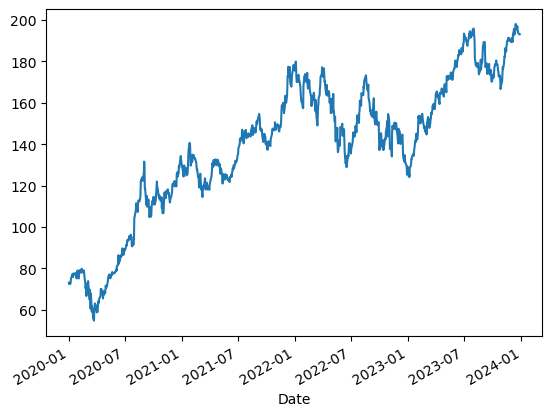

In [65]:
df['Adj Close'].plot()

## Feature engineering

In [66]:
# Moving Average Convergence Divergence (MACD): Identifies trend strength and potential turning points.
macd, signal, hist = MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['Signal'] = signal
df['MACD_Hist'] = hist

In [67]:
# Average True Range (ATR): Measures market volatility.
# Higher ATR values indicate higher market volatility, meaning prices are fluctuating more significantly.
# Lower ATR values indicate lower volatility, suggesting a calmer market with smaller price swings.
# You can use ATR to set stop-loss orders, manage risk, and identify potential trading opportunities based on volatility changes.

close_prices = df["Adj Close"]
high_prices = df["High"]
low_prices = df["Low"]

true_range = pd.Series(
    [max(hi - lo, abs(hi - close_prev), abs(lo - close_prev))
     for hi, lo, close_prev in zip(high_prices, low_prices, close_prices.shift(1))]
)

# Higher -> less sensitive to recent data change 
# Lower -> More sensitive to recent data cahange
# 14: Common window size, which can balance. 
window = 14
atr = true_range.rolling(window=window).mean()

atr_df = pd.DataFrame({'ATR': atr.values}, index=df.index)

# Merge the original DataFrame with the new ATR DataFrame
df = pd.merge(df, atr_df, left_index=True, right_index=True)


In [68]:
# Re-order the data frame

new_order = ["Open", "High", "Low", 'MACD', 'Signal',
       'MACD_Hist', "ATR", "Adj Close"]
df = df[new_order]
df.head()

,Open,High,Low,MACD,Signal,MACD_Hist,ATR,Adj Close
Date,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,NaN,NaN,NaN,NaN,73.152641
2020-01-03,74.287498,75.144997,74.125000,NaN,NaN,NaN,NaN,72.441460
2020-01-06,73.447502,74.989998,73.187500,NaN,NaN,NaN,NaN,73.018684
2020-01-07,74.959999,75.224998,74.370003,NaN,NaN,NaN,NaN,72.675293
2020-01-08,74.290001,76.110001,74.290001,NaN,NaN,NaN,NaN,73.844337


In [69]:
# Drop null values 
df.dropna(inplace=True)


In [70]:
# Select the features and the target 
target_y = df['Adj Close']
X_feat = df.iloc[:,0:7]

X_feat.head()

,Open,High,Low,MACD,Signal,MACD_Hist,ATR
Date,,,,,,,
2020-02-20,80.657501,81.162498,79.552498,0.961544,1.130552,-0.169008,2.755209
2020-02-21,79.654999,80.112503,77.625000,0.733923,1.051226,-0.317303,2.675923
2020-02-24,74.315002,76.044998,72.307503,0.257626,0.892506,-0.634880,2.756670
2020-02-25,75.237503,75.632500,71.532501,-0.315178,0.650969,-0.966147,2.711428
2020-02-26,71.632500,74.470001,71.625000,-0.671361,0.386503,-1.057865,2.754840


In [71]:
# Scale the data using standard scaler 
# Standard scaler will scale between -1 and 1 

sc = StandardScaler() 
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns = X_feat.columns, 
                    data = X_ft, 
                    index = X_feat.index)

X_ft.shape

(971, 7)

In [72]:
# Group features and target into 1 df 
stock_df = pd.concat([X_ft, df['Adj Close']], axis = 1)
stock_df.head()


,Open,High,Low,MACD,Signal,MACD_Hist,ATR,Adj Close
Date,,,,,,,,
2020-02-20,-1.954299,-1.986229,-1.944380,0.051469,0.124912,-0.204677,-1.330678,78.196754
2020-02-21,-1.985889,-2.019232,-2.005260,-0.032746,0.093468,-0.377127,-1.413013,76.426804
2020-02-24,-2.154156,-2.147083,-2.173214,-0.208966,0.030552,-0.746433,-1.329160,72.796486
2020-02-25,-2.125087,-2.160049,-2.197693,-0.420891,-0.065192,-1.131659,-1.376143,70.330704
2020-02-26,-2.238684,-2.196589,-2.194771,-0.552672,-0.170025,-1.238317,-1.331061,71.446411


In [73]:
# Define a function to do split into training and testing 

def lstm_split(data, n_steps):
    X, y = [], []

    for i in range(len(data) - n_steps+1): 
        X.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps -1, -1] )

    return np.array(X), np.array(y) 

In [74]:
# Generate train and test set
X1, y1 = lstm_split(stock_df.values, n_steps = 10) # Predict based on the data of past 2 days 

train_split = 0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = stock_df.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(962, 10, 7) (770, 10, 7) (192, 10, 7) (192,)


## Build a simple LSTM model 

In [75]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                5120      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5153 (20.13 KB)


Trainable params: 5153 (20.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
# Add checkpoint to keep the best epoch 
# from keras.callbacks import ModelCheckpoint
# cp = ModelCheckpoint('model1/', save_best_only=True)

In [77]:
# Fit model to training data 

history = lstm.fit(X_train, y_train,
                   epochs=100, batch_size=4,
                   verbose=2, shuffle=False)

Epoch 1/100
193/193 - 1s - loss: 13275.1641 - 699ms/epoch - 4ms/step
Epoch 2/100
193/193 - 0s - loss: 155087.1406 - 274ms/epoch - 1ms/step
Epoch 3/100
193/193 - 0s - loss: 15320.2119 - 283ms/epoch - 1ms/step
Epoch 4/100
193/193 - 0s - loss: 14348.9521 - 281ms/epoch - 1ms/step
Epoch 5/100
193/193 - 0s - loss: 13017.2441 - 273ms/epoch - 1ms/step
Epoch 6/100
193/193 - 0s - loss: 12183.5762 - 279ms/epoch - 1ms/step
Epoch 7/100
193/193 - 0s - loss: 10718.4473 - 274ms/epoch - 1ms/step
Epoch 8/100
193/193 - 0s - loss: 6620.9609 - 274ms/epoch - 1ms/step
Epoch 9/100
193/193 - 0s - loss: 3363.0129 - 293ms/epoch - 2ms/step
Epoch 10/100
193/193 - 0s - loss: 2217.0291 - 275ms/epoch - 1ms/step
Epoch 11/100
193/193 - 0s - loss: 1455.1506 - 274ms/epoch - 1ms/step
Epoch 12/100
193/193 - 0s - loss: 974.6544 - 271ms/epoch - 1ms/step
Epoch 13/100
193/193 - 0s - loss: 728.9037 - 273ms/epoch - 1ms/step
Epoch 14/100
193/193 - 0s - loss: 567.6974 - 274ms/epoch - 1ms/step
Epoch 15/100
193/193 - 0s - loss: 453.

In [78]:
from tensorflow.keras.models import load_model

try:
    # Load the model from the specified directory
    model = load_model('model1/')
    print("Model loaded successfully.")
except Exception as e:
    print("Error loading the model:", e)


Error loading the model: SavedModel file does not exist at: model1//{saved_model.pbtxt|saved_model.pb}


## Performance evaluation 

In [79]:
# Evaluate the performance on a test set 

y_pred = lstm.predict(X_test)
y_pred.shape

6/6 [==============================] - 0s 877us/step


(192, 1)

In [80]:
print(y_pred.shape)
print(y_test.shape)

(192, 1)
(192,)


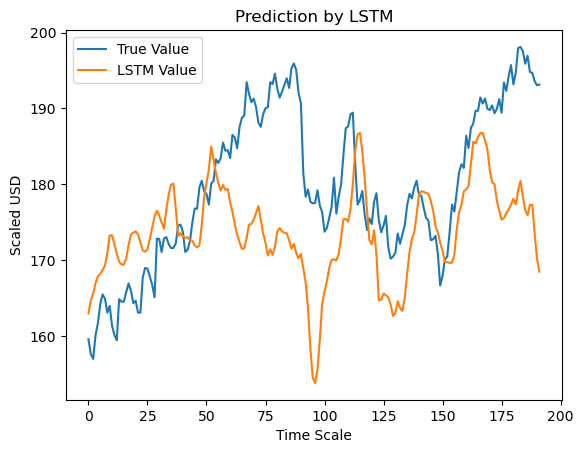

In [81]:
#Predicted vs True Adj Close Value – LSTM

plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [82]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)

print("RMSE: ", rmse)
print("MAPE: ", mape)
print(f'Mean Absolute Error (MAE): {mae}')
print("R-Squared: ", rsquared)


RMSE:  11.404455455509432
MAPE:  0.0511500308684793
Mean Absolute Error (MAE): 9.373723030090332
R-Squared:  -0.2531085170789982


## Improved version of LSTM